In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import sys
from tqdm import tqdm
import os
%matplotlib inline

In [33]:
prometheus_endpoint = '10.9.8.136'
prometheus_port = '9090'
print("Collecting data from Monitoring at: {}".format(prometheus_endpoint))
prometheus_query = {"query": '''{__name__=~"node.+"}[40m]'''}
try:
    url = '/api/v1/query'
    resp = requests.get('http://{}:{}{}'.format(prometheus_endpoint, prometheus_port, url), params=prometheus_query)
except Exception as inst:
    print("Error fetching data")

In [34]:
def prtoDF(data,
           verbose=False,
           index=None):
    """
    From PR backend to dataframe
    :param data: PR response JSON
    :return: dataframe
    """
    if not data:
        print("No data has been received!")
        sys.exit(2)
    df = pd.DataFrame()
    df_time = pd.DataFrame()
    if verbose:
        dr = tqdm(data['data']['result'])
    else:
        dr = data['data']['result']
    for el in dr:
        metric_name = el['metric']['__name__']
        instance_name = el['metric']['instance']
        new_metric = "{}_{}".format(metric_name, instance_name)
        values = el['values']
        proc_val = []
        proc_time = []
        for val in values:
            proc_val.append(val[1])
            proc_time.append(val[0])
        df[new_metric] = proc_val
        time_new_metric = "time_{}".format(new_metric)
        df_time[time_new_metric] = proc_time
    # Calculate the meant time for all metrics
    df_time['mean'] = df_time.mean(axis=1)
    # Round to np.ceil all metrics
    df_time['mean'] = df_time['mean'].apply(np.ceil)
    # Add the meant time to rest of metrics
    df['time'] = df_time['mean']
    print("[INFO] PR query resulted in dataframe of size: {}".format(df.shape))
    if index is not None:
        df.set_index(index, inplace=True)
        print('[WARN] PR query dataframe index set to  {}'.format( index))
    return df

df_bd_lab = prtoDF(resp.json(), verbose=True, index='time')

100%|██████████| 408/408 [00:00<00:00, 606.42it/s]

[INFO] PR query resulted in dataframe of size: (2400, 194)
[WARN] PR query dataframe index set to  time


In [35]:
df_bd_lab = df_bd_lab.astype(np.float64)

<AxesSubplot:xlabel='time'>

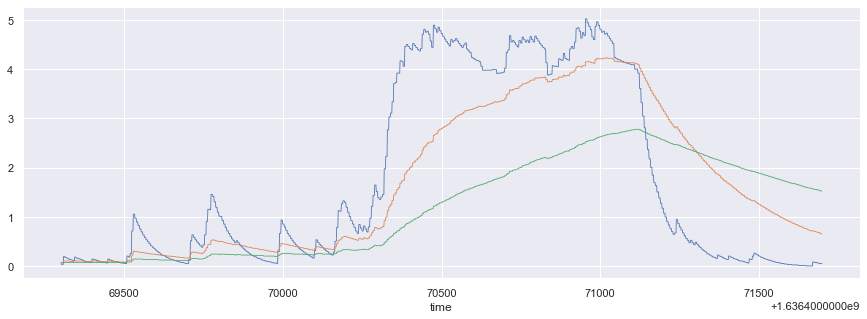

In [38]:
sns.set(rc={'figure.figsize':(15, 5)})
df_bd_lab["node_load1_10.211.55.101:9100"].plot(linewidth=0.8)
df_bd_lab["node_load5_10.211.55.101:9100"].plot(linewidth=0.8)
df_bd_lab["node_load15_10.211.55.101:9100"].plot(linewidth=0.8)
# df_bd_lab["node_load1_10.211.55.101:9100"].plot(linewidth=0.8)

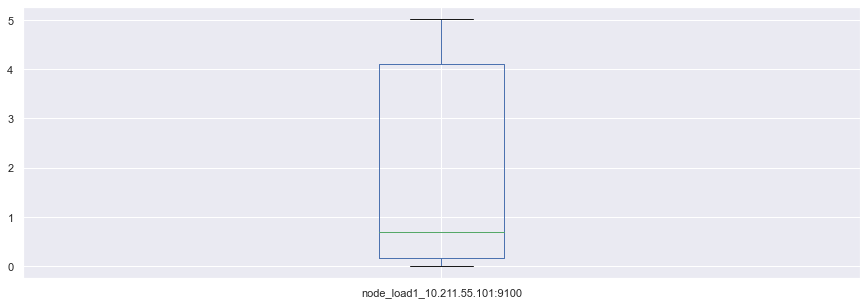

In [40]:
df_bd_lab["node_load1_10.211.55.101:9100"].plot.box();


In [41]:
df_bd_lab.columns


Index(['node_arp_entries_10.211.55.101:9100',
       'node_boot_time_seconds_10.211.55.101:9100',
       'node_context_switches_total_10.211.55.101:9100',
       'node_cpu_guest_seconds_total_10.211.55.101:9100',
       'node_cpu_seconds_total_10.211.55.101:9100',
       'node_disk_io_now_10.211.55.101:9100',
       'node_disk_io_time_seconds_total_10.211.55.101:9100',
       'node_disk_io_time_weighted_seconds_total_10.211.55.101:9100',
       'node_disk_read_bytes_total_10.211.55.101:9100',
       'node_disk_read_time_seconds_total_10.211.55.101:9100',
       ...
       'node_timex_tai_offset_seconds_10.211.55.101:9100',
       'node_timex_tick_seconds_10.211.55.101:9100',
       'node_uname_info_10.211.55.101:9100',
       'node_vmstat_oom_kill_10.211.55.101:9100',
       'node_vmstat_pgfault_10.211.55.101:9100',
       'node_vmstat_pgmajfault_10.211.55.101:9100',
       'node_vmstat_pgpgin_10.211.55.101:9100',
       'node_vmstat_pgpgout_10.211.55.101:9100',
       'node_vmstat_psw

<AxesSubplot:xlabel='time'>

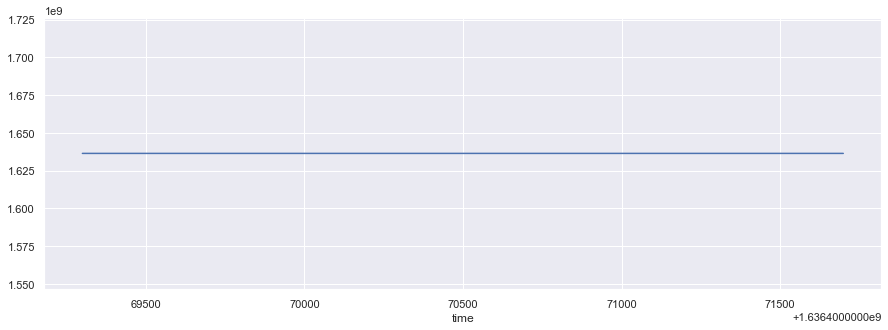

In [42]:
df_bd_lab["node_boot_time_seconds_10.211.55.101:9100"].plot()


In [45]:
# df_bd_lab.fillna(0.0, inplace=True)
df_bd_lab.dropna(axis=1, inplace=True)


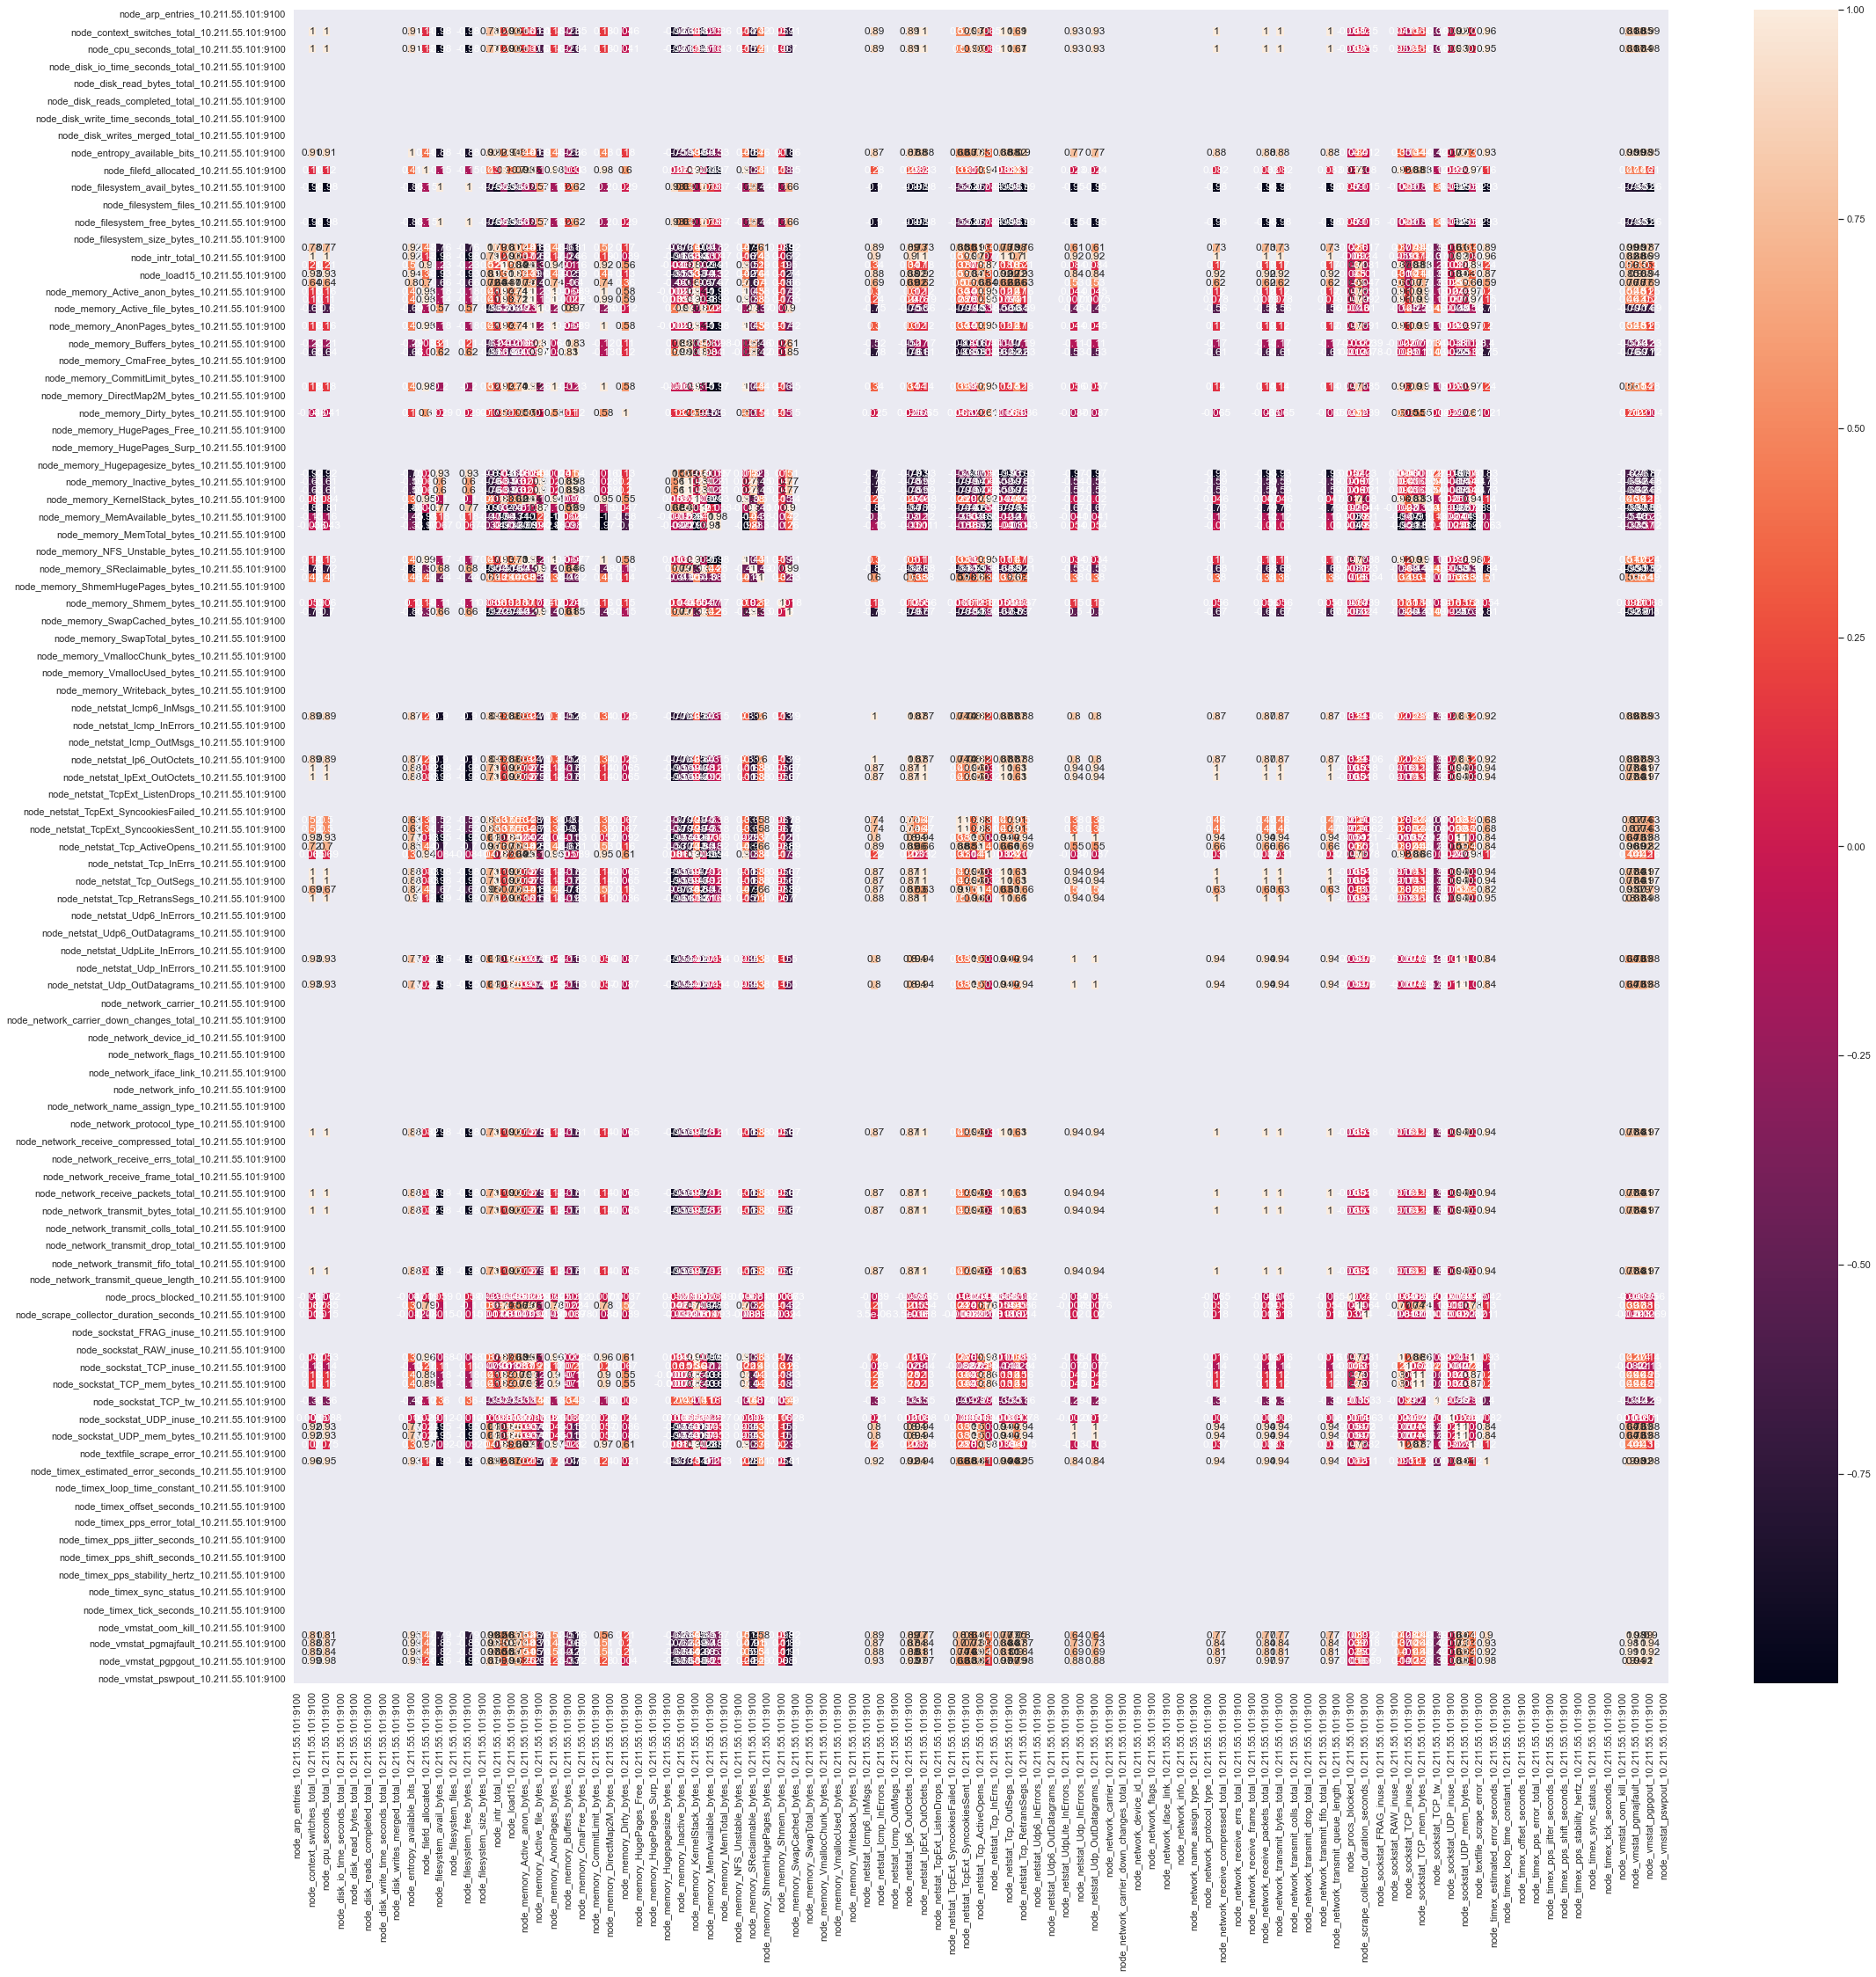

In [47]:
df_bd_lab.shape

# Pearson correlation
plt.subplots(figsize=(35, 35))
sns.heatmap(df_bd_lab.corr(), annot=True)
plt.show()


In [48]:
uniques_au_a = df_bd_lab.apply(lambda x: x.nunique())
rm_columns = []
for uindex, uvalue in uniques_au_a.iteritems():
    if uvalue == 1:
        rm_columns.append(uindex)

print("Columns to be removed: {}".format(rm_columns))
print("Total: {}".format(len(rm_columns)))



Columns to be removed: ['node_arp_entries_10.211.55.101:9100', 'node_boot_time_seconds_10.211.55.101:9100', 'node_cpu_guest_seconds_total_10.211.55.101:9100', 'node_disk_io_now_10.211.55.101:9100', 'node_disk_io_time_seconds_total_10.211.55.101:9100', 'node_disk_io_time_weighted_seconds_total_10.211.55.101:9100', 'node_disk_read_bytes_total_10.211.55.101:9100', 'node_disk_read_time_seconds_total_10.211.55.101:9100', 'node_disk_reads_completed_total_10.211.55.101:9100', 'node_disk_reads_merged_total_10.211.55.101:9100', 'node_disk_write_time_seconds_total_10.211.55.101:9100', 'node_disk_writes_completed_total_10.211.55.101:9100', 'node_disk_writes_merged_total_10.211.55.101:9100', 'node_disk_written_bytes_total_10.211.55.101:9100', 'node_exporter_build_info_10.211.55.101:9100', 'node_filefd_maximum_10.211.55.101:9100', 'node_filesystem_device_error_10.211.55.101:9100', 'node_filesystem_files_10.211.55.101:9100', 'node_filesystem_files_free_10.211.55.101:9100', 'node_filesystem_readonly_

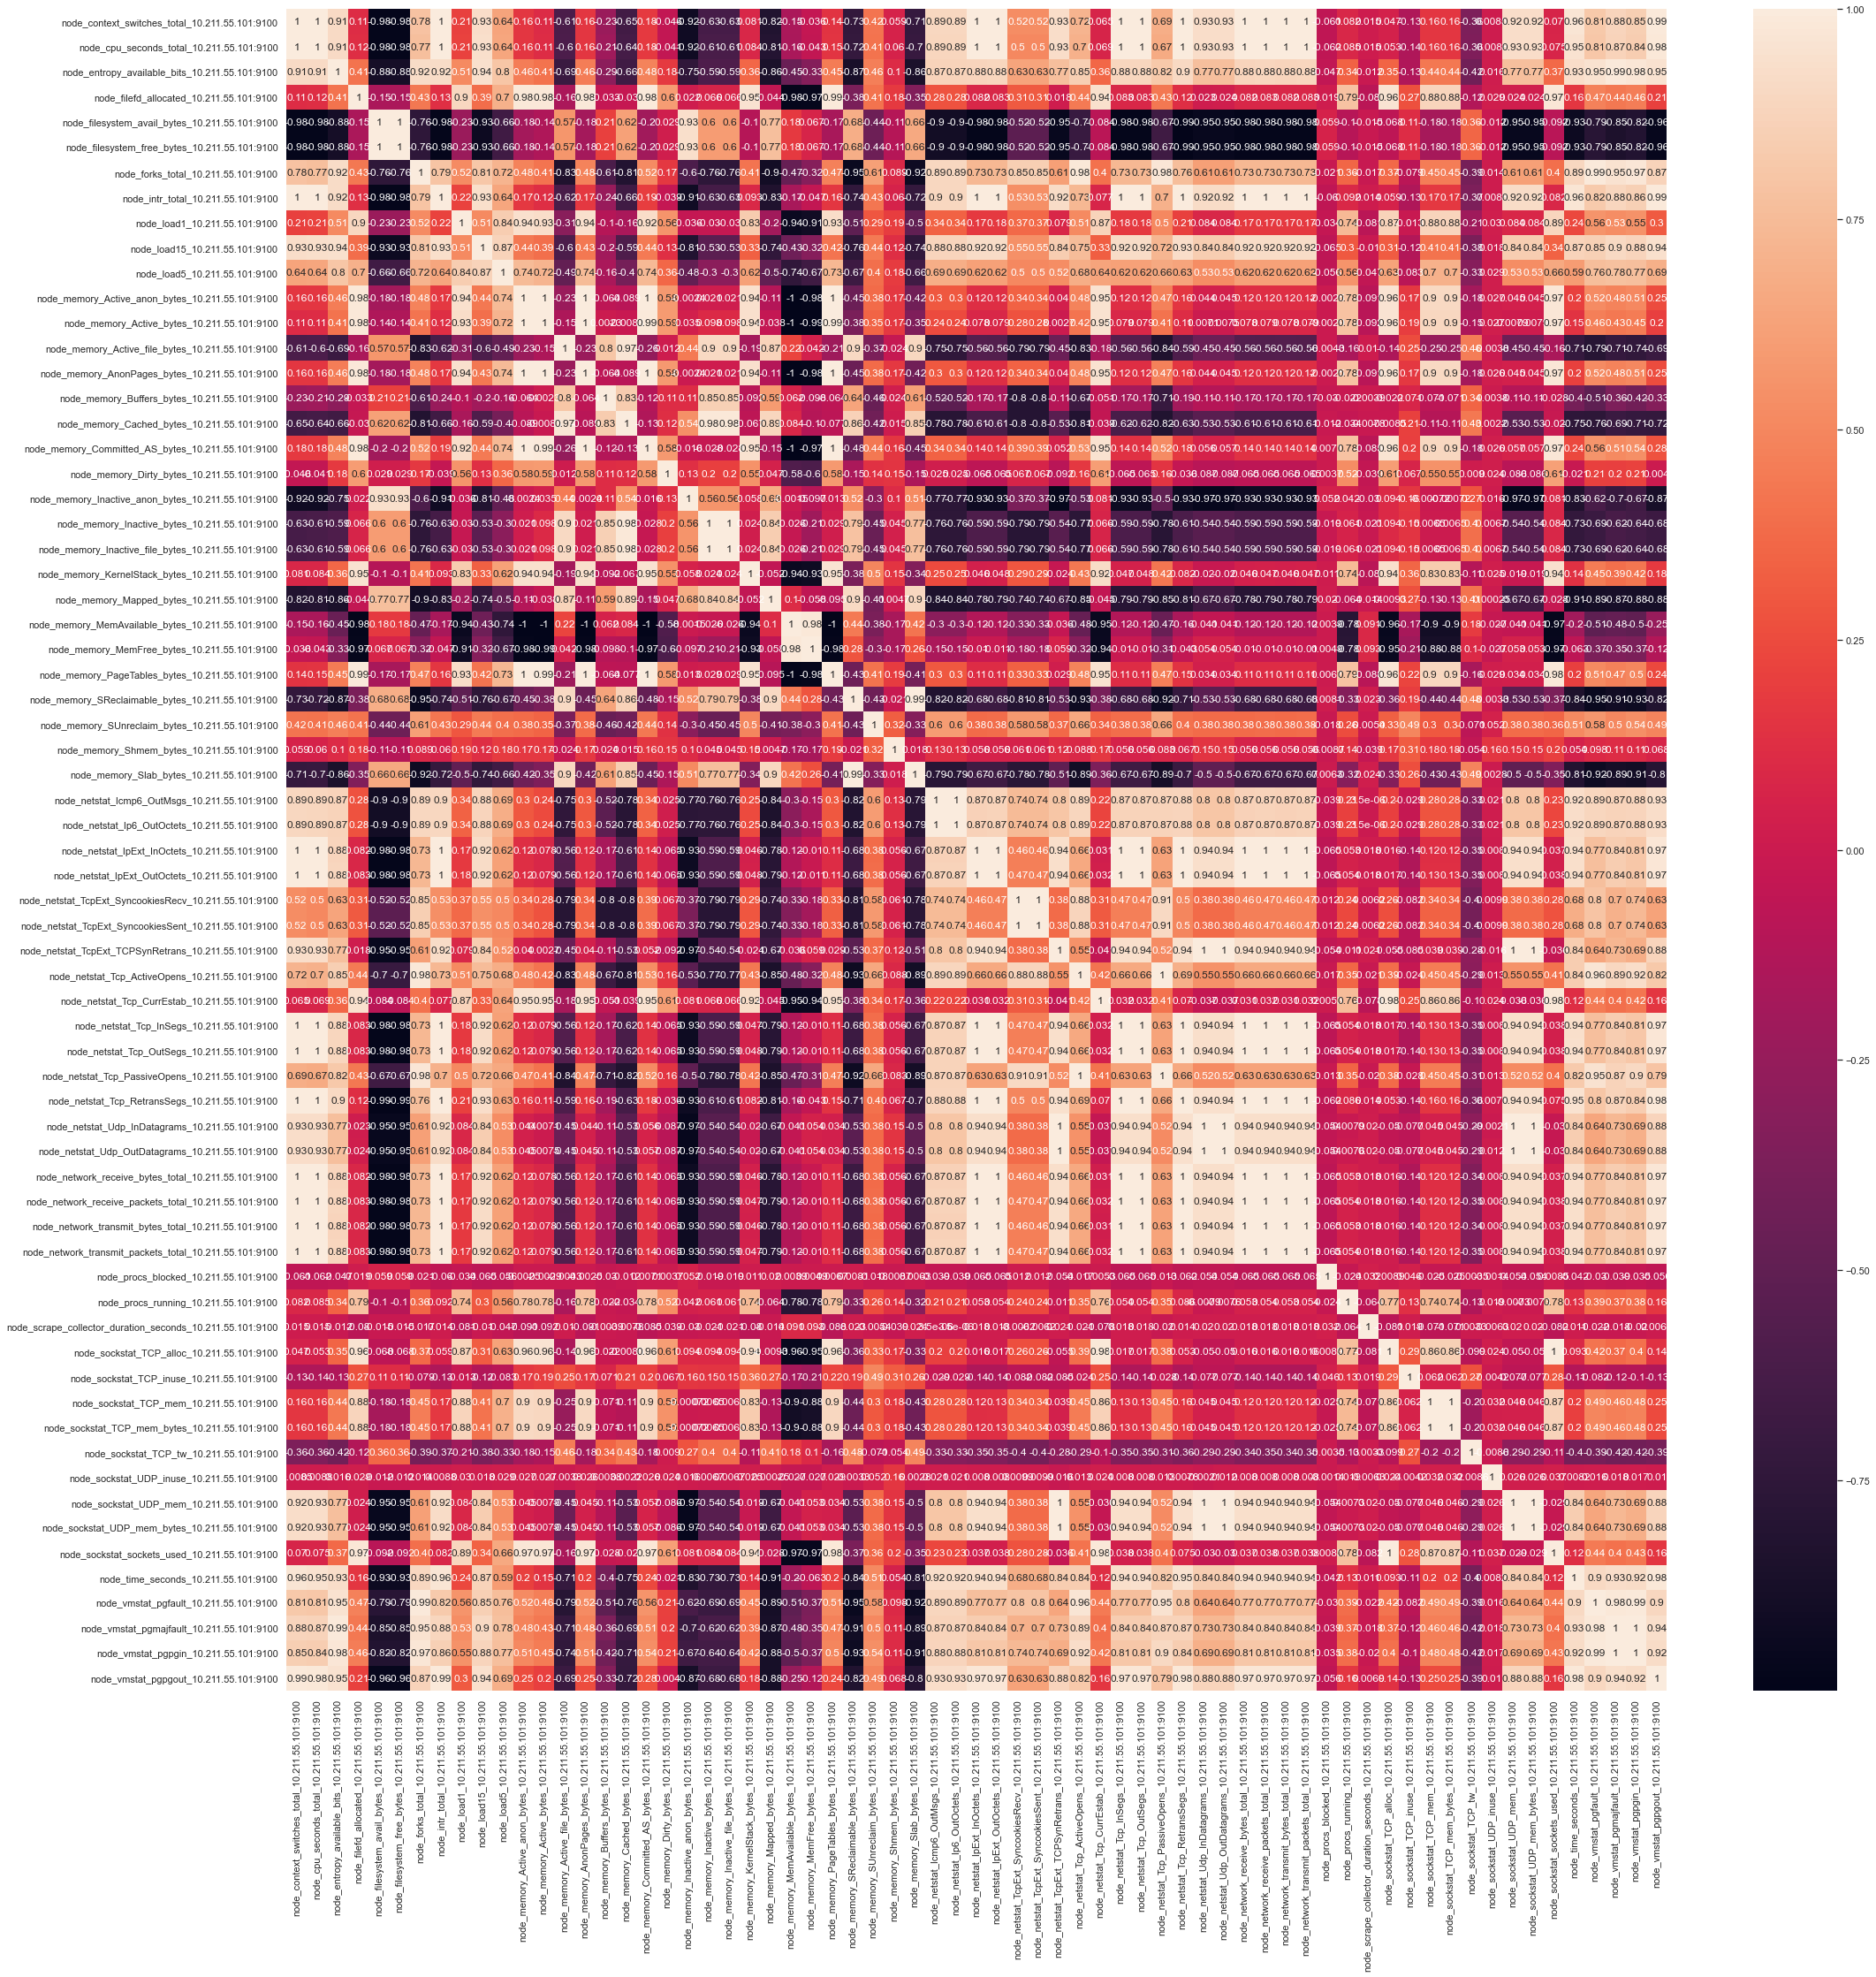

In [49]:
df_bd_lab_rm =  df_bd_lab.drop(rm_columns, axis=1)
# Pearson correlation
plt.subplots(figsize=(35, 35))
sns.heatmap(df_bd_lab_rm.corr(), annot=True)
plt.show()